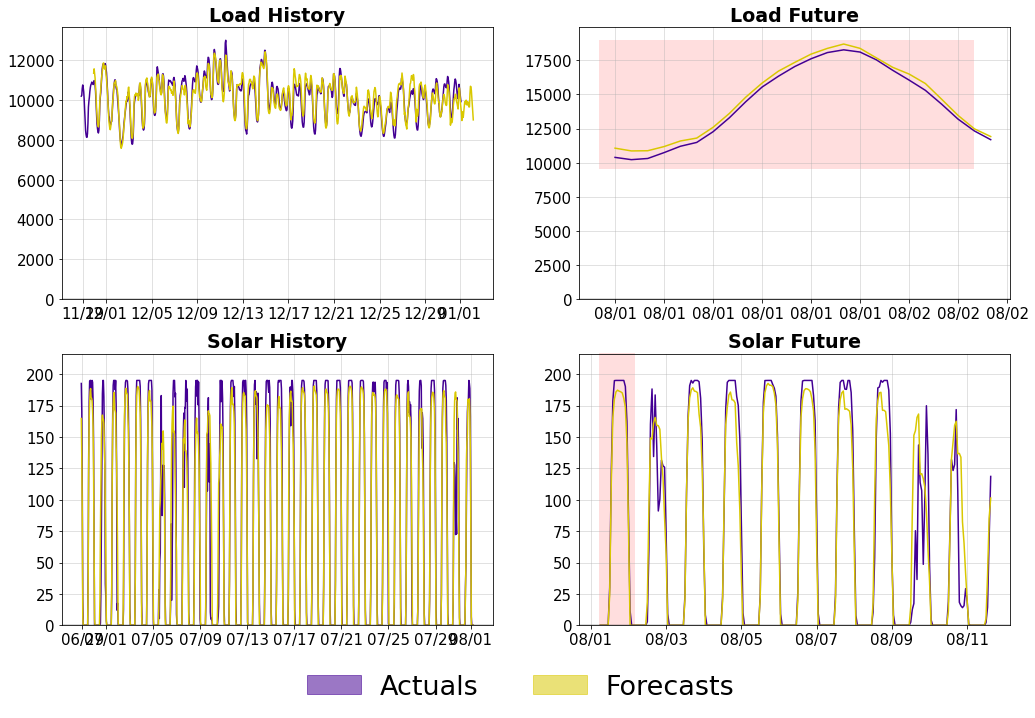

In [1]:
from pathlib import Path
import pandas as pd
from pgscen.command_line import (
    load_load_data, load_solar_data,
    split_actuals_hist_future, split_forecasts_hist_future
    )

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 11]
from IPython.display import display

start_date = '2018-08-01'
cur_path = Path("day-ahead_solar.ipynb").parent.resolve()
data_dir = Path(cur_path, '..', "data").resolve()

scenario_count = 1000
scen_start_time = pd.to_datetime(' '.join([start_date, "06:00:00"]), utc=True)
scen_timesteps = pd.date_range(start=scen_start_time, periods=24, freq='H')

load_zone_actual_df, load_zone_forecast_df = load_load_data()
(solar_site_actual_df, solar_site_forecast_df,
     solar_meta_df) = load_solar_data()

(load_zone_actual_hists,
    load_zone_actual_futures) = split_actuals_hist_future(
            load_zone_actual_df, scen_timesteps, in_sample=True)
(load_zone_forecast_hists,
     load_zone_forecast_futures) = split_forecasts_hist_future(
            load_zone_forecast_df, scen_timesteps, in_sample=True)

(solar_site_actual_hists,
     solar_site_actual_futures) = split_actuals_hist_future(
            solar_site_actual_df, scen_timesteps)
(solar_site_forecast_hists,
     solar_site_forecast_futures) = split_forecasts_hist_future(
            solar_site_forecast_df, scen_timesteps)

fig, ((load_hist_ax, load_future_ax),
      (solar_hist_ax, solar_future_ax)) = plt.subplots(
    figsize=(17, 11), nrows=2, ncols=2)

title_args = dict(weight='semibold', size=19)
actual_clr, fcst_clr = "#430093", "#D9C800"
load_plt_asset = 'Coast'
solar_plt_asset = 'Angelo Solar'

load_hist_ax.set_title("Load History", **title_args)
load_hist_ax.plot(load_zone_actual_hists[load_plt_asset][-800:], c=actual_clr)
load_hist_ax.plot(load_zone_forecast_hists['Forecast_time'][-800:],
                  load_zone_forecast_hists[load_plt_asset][-800:],
                  c=fcst_clr)
load_hist_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

load_future_ax.set_title("Load Future", **title_args)
load_future_ax.plot(load_zone_actual_futures[load_plt_asset][:250], c=actual_clr)
load_future_ax.plot(load_zone_forecast_futures['Forecast_time'][:250],
                    load_zone_forecast_futures[load_plt_asset][:250], c=fcst_clr)
load_future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

solar_hist_ax.set_title("Solar History", **title_args)
solar_hist_ax.plot(solar_site_actual_hists[solar_plt_asset][-800:], c=actual_clr)
solar_hist_ax.plot(solar_site_forecast_hists['Forecast_time'][-800:],
                   solar_site_forecast_hists[solar_plt_asset][-800:],
                   c=fcst_clr)
solar_hist_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

solar_future_ax.set_title("Solar Future", **title_args)
solar_future_ax.plot(solar_site_actual_futures[solar_plt_asset][:250], c=actual_clr)
solar_future_ax.plot(solar_site_forecast_futures['Forecast_time'][:250],
                     solar_site_forecast_futures[solar_plt_asset][:250], c=fcst_clr)
solar_future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

load_future_ax.fill_between(load_zone_actual_futures.index[:24] - pd.Timedelta(hours=1),
                            load_zone_actual_futures[load_plt_asset][:24].min() - 700,
                            load_zone_actual_futures[load_plt_asset][:24].max() + 700,
                            facecolor='red', edgecolor='none', alpha=0.13)

solar_future_ax.fill_between(solar_site_actual_futures.index[:24] - pd.Timedelta(hours=1),
                             solar_site_actual_futures[solar_plt_asset][:24].min() - 700,
                             solar_site_actual_futures[solar_plt_asset][:24].max() + 700,
                             facecolor='red', edgecolor='none', alpha=0.13)

for ax in [load_hist_ax, load_future_ax, solar_hist_ax, solar_future_ax]:
    ax.tick_params(which='both', labelsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)

for ax in [load_hist_ax, load_future_ax]:
    ax.set_ylim((0, ax.get_ylim()[1]))
    
for ax in [solar_hist_ax, solar_future_ax]:
    ax.set_ylim((0, solar_meta_df.AC_capacity_MW[solar_meta_df.site_ids
                                                 == solar_plt_asset].values[0] * 1.11))

lgnd_ptchs = [Patch(color=actual_clr, alpha=0.53, label="Actuals"),
              Patch(color=fcst_clr, alpha=0.53, label="Forecasts")]

_ = fig.legend(handles=lgnd_ptchs, frameon=False, fontsize=27, ncol=2, loc=8,
               bbox_to_anchor=(0.5, 0), handletextpad=0.7)

In [2]:
from pgscen.pca import PCAGeminiEngine

se = PCAGeminiEngine(solar_site_actual_hists, solar_site_forecast_hists,
                       scen_start_time, solar_meta_df)

In [16]:
dist = se.asset_distance().values
se.fit_load_solar_joint_model(load_zone_actual_hists,
                              load_zone_forecast_hists,
                              load_asset_rho=5e-2, load_horizon_rho=5e-2,
                              solar_asset_rho=dist / (1 * dist.max()), 
                              solar_pca_comp_rho=1e-1,
                              joint_asset_rho=1e-1
                             )

/Users/xy3134/Research/PERFORM/SoftwareDev/new/PGscen/pgscen/model.py:212: RuntimeWarning: unable to find actual data to be matched with forecast issued at 2018-12-30 18:00:00+00:00
  warnings.warn(
/Users/xy3134/Research/PERFORM/SoftwareDev/new/PGscen/pgscen/model.py:212: RuntimeWarning: unable to find actual data to be matched with forecast issued at 2018-12-31 18:00:00+00:00
  warnings.warn(
/Users/xy3134/Research/PERFORM/SoftwareDev/new/PGscen/pgscen/pca.py:340: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  load_solar_zone_gauss_df = joint_load_df.merge(solar_zone_gauss_df, how='inner',


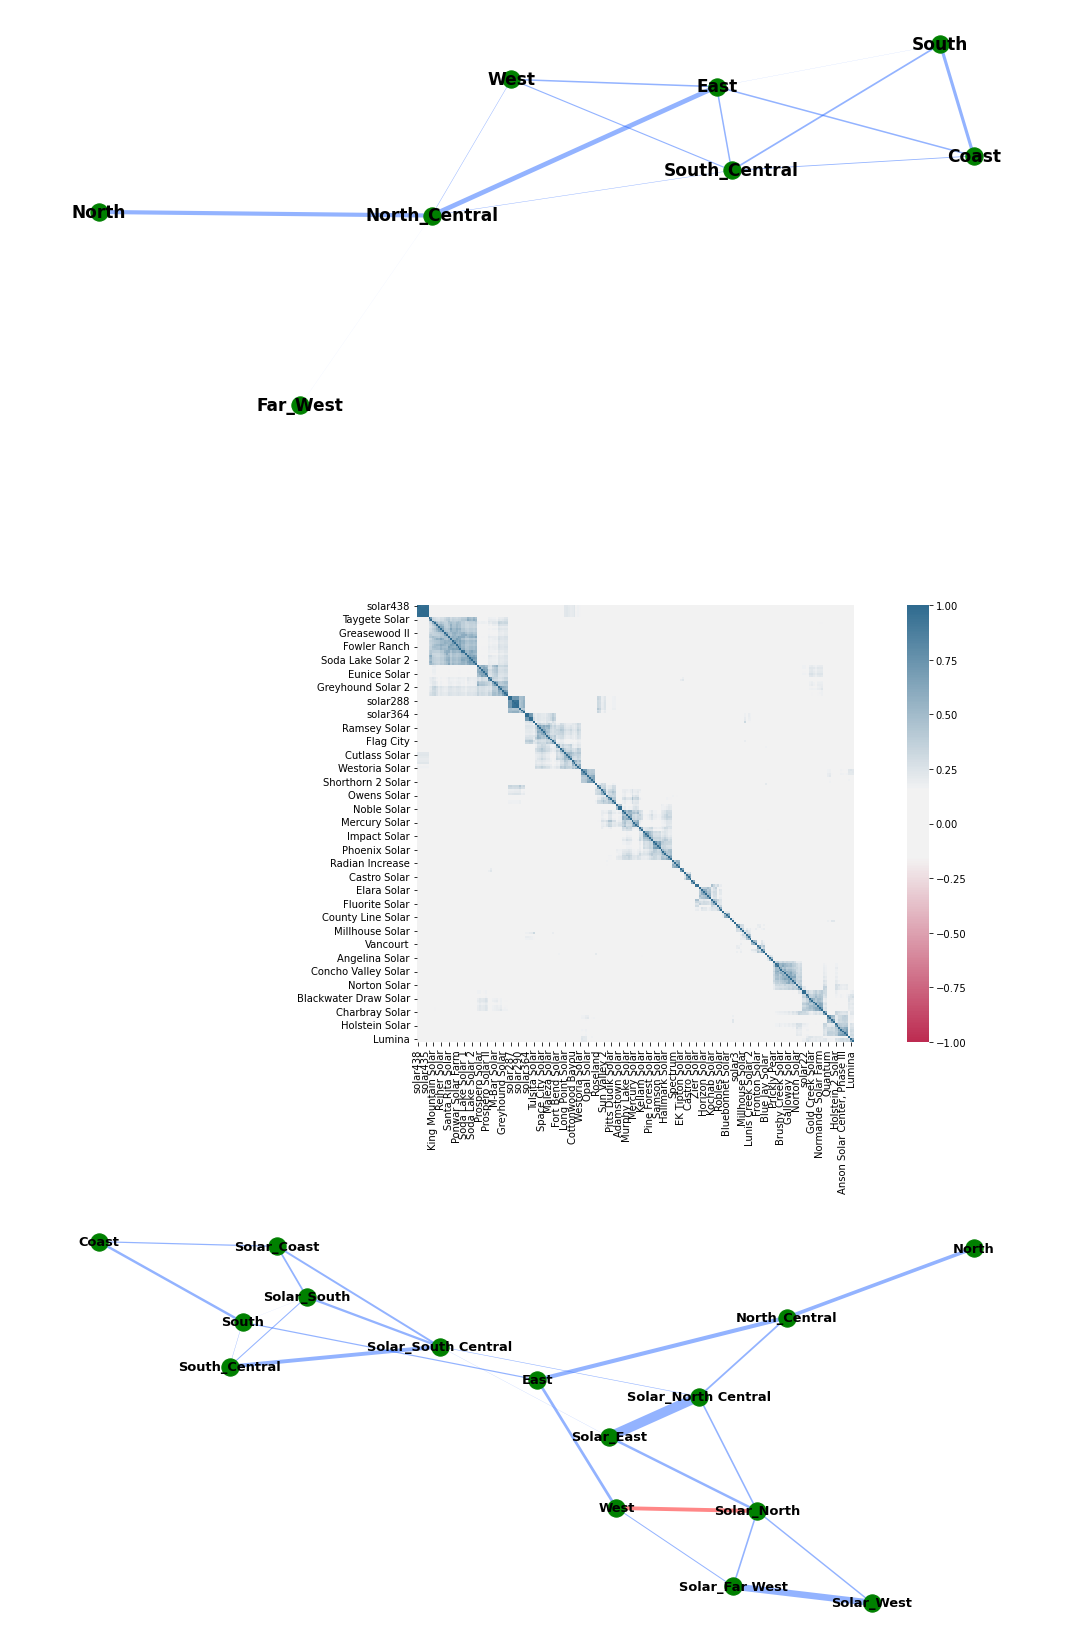

In [40]:
import numpy as np
import seaborn as sns
from pgscen.utils.plot_utils import get_clustermat, cov_cmap
from itertools import combinations as combn
import networkx as nx


def draw_pcor_graph(pcor_mat, asset_list, ax, plt_thresh, **nxargs):
    asset_graph = nx.Graph()

    for (i, asset1), (j, asset2) in combn(enumerate(asset_list), 2):
        if np.abs(pcor_mat[i, j]) >= plt_thresh:
            asset_graph.add_edge(asset1, asset2, pcor=pcor_mat[i, j])
    
    nx.draw(asset_graph, ax=ax, with_labels=True, 
            node_color='green', font_weight='bold',
            edge_color=[(0.10, 0.37, 1., 0.47) if val > 0 else (1., 0., 0., 0.47)
                        for val in nx.get_edge_attributes(asset_graph, 'pcor').values()],
            width=[20 * (val - plt_thresh)
                   for val in nx.get_edge_attributes(asset_graph, 'pcor').values()],
            **nxargs)


fig, (load_ax, solar_ax, joint_ax) = plt.subplots(
    figsize=(15, 23), nrows=3, ncols=1)

load_cov = se.load_md.asset_cov
load_prec = np.linalg.inv(load_cov)
load_pcor = -load_prec / np.sqrt(np.outer(np.diag(load_prec),
                                          np.diag(load_prec)))
draw_pcor_graph(load_pcor, load_cov.index, load_ax, 0.05, font_size=17)


solar_cov = se.solar_md.asset_cov
D = np.sqrt(np.diag(solar_cov))
corr_mat = (D ** -1) * solar_cov * (D ** -1)

solar_clust = get_clustermat(corr_mat)
sns.heatmap(solar_clust, ax=solar_ax, cmap=cov_cmap,
            vmin=-1, vmax=1, square=True)


joint_cov = se.joint_md['asset_cov']
joint_prec = np.linalg.inv(joint_cov)
joint_pcor = -joint_prec / np.sqrt(np.outer(np.diag(joint_prec),
                                            np.diag(joint_prec)))

draw_pcor_graph(joint_pcor, joint_cov.index, joint_ax, 0.08, font_size=13)

    
fig.tight_layout()    